In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import csv
import glob
import codecs
import json
import re
import random
random.seed(151)

In [3]:
from collections import defaultdict

In [4]:
import nltk
import janome.tokenizer

In [5]:
import numpy as np
import pandas as pd
np.random.seed(151)

In [6]:
from sklearn.metrics import classification_report

In [7]:
from chainer import Variable, Chain, reporter, configuration
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater, Trainer
from chainer.training.extensions import PrintReport, LogReport, Evaluator, observe_value, snapshot_object
from chainer.training.triggers import MinValueTrigger

# Deep Learningドリル - 応用編（言語処理）-

前章ではDeep Learningによる画像処理を体験していただきました。

この章では、時系列データ、特に言語データにおけるDeep Learningでの取り扱いについて学びましょう。

## 例題

あなたは、ブログサービスを運営する会社に務めています。あなたの所属する部署では、ユーザーがブログに書いた記事を分野ごとに自動で分類し、ブログ記事ランキングを作ることになりました。

あなたはこのプロジェクトのR&D部門で学習アルゴリズムの設計開発を命じられました。プロトタイプを作成してみましょう。

【注意】お使いのPythonバージョンなどによって、期待した性能が出ないことがあります(乱数の出方によって局所解に落ちやすいため)。その時は2行目と5行目の乱数seedを適当に変えて試してみてください。

## コーパスのダウンロード

学習に使うコーパス(文と正解データの集合)をダウンロードしましょう。

In [8]:
if not os.path.exists("nltk_data/corpora/knbc"):
    os.makedirs("nltk_data/corpora/knbc")
    nltk.download("knbc", download_dir="nltk_data")

## データのロード

ダウンロードしたデータは以下のような4つのファイルを含みます。詳しくは付属の仕様書をご覧ください。

In [9]:
ls nltk_data/corpora/knbc/corpus2

パラメーターの形式が誤っています - "corpora"


日本語を単語に分かち書きするためにjanomeを使います。

In [10]:
tokenizer = janome.tokenizer.Tokenizer()

In [11]:
import unicodedata

In [12]:
repeat = re.compile("([!?。、\.,])+")
class Document(object):
    def __init__(self, category):
        self.sentences = []
        self.category = category
        
    def add(self, sentence):
        self.sentences.append(sentence)
    
    @property
    def words(self):
        words = []
        for sentence in self.sentences:
            words += sentence.words
        return words
    
    def __iter__(self):
        for sentence in self.sentences:
            yield sentence
    
    def __len__(self):
        return len(self.sentences)

class Sentence(object):
    def __init__(self, sentence_id, sentence):
        self.sentence_id = sentence_id.strip()
        self.sentence = sentence.strip()
        
        # テキスト正規化
        normalized = unicodedata.normalize("NFKC", self.sentence).lower()
        normalized = repeat.sub(r"\1", normalized)
        
        # 形態素解析(分かち書き)
        tokens = tokenizer.tokenize(normalized)
        
        # 形態素解析の結果を単語のリストに変換します。
        self.words = list(map(lambda t: t.surface, tokens))
        
    @property
    def document_id(self):
        return self.sentence_id.split("-")[0]

In [13]:
def get_category(path):
    name = os.path.basename(path)
    category, _ = os.path.splitext(name)
    return category

In [14]:
files = glob.glob("nltk_data/corpora/knbc/corpus2/*.tsv")
documents = dict()
categories = dict()
for filepath in files:
    category = get_category(filepath)
    
    if category=="Sports":
        # スポーツは文書の数がとても少なく学習できないので除外します。
        continue
        
    categories[category] = len(categories)
    with codecs.open(filepath, "r", "euc-jp") as fp:
        reader = csv.reader(fp, delimiter="\t")
        for row in reader:
            sentence = Sentence(row[0], row[1])
            if sentence.document_id not in documents:
                # 先頭行はタイトルなので、オブジェクトだけ作って記事の追加はスキップします。
                documents[sentence.document_id] = Document(category)
            else:
                doc = documents[sentence.document_id]
                assert doc.category == category
                doc.add(sentence)

In [15]:
dataset = []
for doc in documents.values():
    if len(doc) == 0:
        # 本文が存在しない文書はスキップします
        continue
    dataset.append(doc)
    #print(doc.words)

文書数と文数を確認しておきましょう。

In [16]:
len(dataset), sum([len(d) for d in dataset])

(227, 3437)

## データの分割

学習データ、開発データ、テストデータに分けます。

In [17]:
ls data

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は 5028-F110 です

 C:\Users\Hiroshi.Hiromax\Downloads\Homework-master-ab83c0f2dc938cf3204ec3fcbaff174909161ba8\data のディレクトリ

2017/11/11  09:56    <DIR>          .
2017/11/11  09:56    <DIR>          ..
2017/11/07  17:24             4,105 7_dataset.json
2017/11/07  17:24         5,059,737 dev.csv
2017/11/07  17:24               114 README
2017/11/07  17:24        20,234,624 test.csv
2017/11/07  17:24        45,378,950 train.csv
               5 個のファイル          70,677,530 バイト
               2 個のディレクトリ  363,148,976,128 バイトの空き領域


In [18]:
with open("data/7_dataset.json") as fp:
    split_info = json.loads(fp.read())

In [19]:
id_to_doc = dict()
for doc in dataset:
    id_to_doc[doc.sentences[0].document_id] = doc

train_all = []
dev = []
test = []

for document_id in split_info["train_ids"]:
    train_all.append(id_to_doc[document_id])

for document_id in split_info["dev_ids"]:
    dev.append(id_to_doc[document_id])

for document_id in split_info["test_ids"]:
    test.append(id_to_doc[document_id])

In [20]:
len(train_all), len(dev), len(test)

(144, 37, 46)

In [21]:
max([len(doc.words) for doc in train_all])

1080

## 前処理

長すぎる文書は学習速度を低下させてしまうので400単語より長い文書は削除しましょう。

In [22]:
train = []
for doc in train_all:
    if len(doc.words) <= 400:
        train.append(doc)

In [23]:
n_doc_train = len(train)
n_doc_dev = len(dev)
n_doc_test = len(test)

In [24]:
n_doc_train, n_doc_dev, n_doc_test

(120, 37, 46)

各単語にIDを振ります。

In [25]:
# ほとんど出てこない単語は、学習したとしても信ぴょう性が疑われるため、学習対象から除外します。
# 今回は1回しか出てこない単語を除外します。
vocab_count = defaultdict(lambda: 0)
for doc in train:
    for word in doc.words:
        vocab_count[word] += 1

ignore = []
for word, count in vocab_count.items():
    if count < 2:
        ignore.append(word)

ignore = set(ignore)

# 除外単語に含まれない単語にIDを振ります。
vocab = dict()
for doc in train:
    for word in doc.words:
        if word not in ignore and word not in vocab:
            # 単語IDは必ず1以上になるようにしておく(ID=0に未知語を割り当てたいため)
            vocab[word] = len(vocab) + 1

文書ベクトルを作りましょう。まずは文書の最大長を調べておきます。

In [26]:
n_max_words_train = max([len(doc.words) for doc in train])
n_max_words_dev = max([len(doc.words) for doc in dev])
n_max_words_test = max([len(doc.words) for doc in test])

In [27]:
n_max_words_train, n_max_words_dev, n_max_words_test

(391, 573, 584)

得られた最大長を使って、文書ベクトルを作ります。

In [28]:
def create_document_array(n_doc, n_max_words, dataset):
    ary = -np.ones((n_doc, n_max_words), dtype=np.int32)
    for i, doc in enumerate(dataset):
        for j, word in enumerate(doc.words):
            # 未知語はID=0
            ary[i, j] = vocab.get(word, 0)
    return ary

train_x = create_document_array(n_doc_train, n_max_words_train, train)
dev_x = create_document_array(n_doc_dev, n_max_words_dev, dev)
test_x = create_document_array(n_doc_test, n_max_words_test, test)

正解データを用意しましょう。

In [29]:
def create_ground_truth_array(n_doc, dataset):
    ary = np.zeros((n_doc,), dtype=np.int32)
    
    for i, doc in enumerate(dataset):
        ary[i] = categories[doc.category]
    return ary

train_y = create_ground_truth_array(n_doc_train, train)
dev_y = create_ground_truth_array(n_doc_dev, dev)
test_y = create_ground_truth_array(n_doc_test, test)

In [30]:
np.bincount(train_y)

array([31, 41, 48], dtype=int64)

In [31]:
train_y.shape, n_doc_train

((120,), 120)

## モデル

データの準備ができましたのでモデルを作っていきましょう。今回はLSTM1層、全結合層1層の単純なモデルを使います。

In [32]:
# embeddingの次元数を変数に入れておきます。(後で使います。)
# サイズは、通常 100 〜 500程度を設定しますが、データ量が少なすぎてあっという間に過学習してしまうので少なめにセットします。
embedding_size = 10

class Model(Chain):
    def __init__(self, initialW=None):
        super(Model, self).__init__()
        self.n_out = 5
        with self.init_scope():
            self.embed = L.EmbedID(len(vocab) + 1, embedding_size, ignore_label=-1, initialW=initialW)
            
            self.lstm = L.LSTM(embedding_size, self.n_out)
            self.linear = L.Linear(self.n_out, len(categories))
    
    def __call__(self, x):
        """
        x: shape of (batch_size, sentence_length)
        """
        self.lstm.reset_state()
        zeros = Variable(np.zeros((x.shape[0], self.n_out), dtype=np.float32))
        
        # 単語ごとに文脈ベクトルhを作り、hsという変数に格納しておきます。
        total = Variable(np.zeros_like(zeros, dtype=np.float32))
        counts = np.zeros(x.shape[0], dtype=np.float32)
        for i in range(x.shape[1]):
            word_ids = x[:, i]
            finished = word_ids == -1
            if np.all(finished):
                continue

            h = self.embed(word_ids)
            h = F.dropout(h)
            h = self.lstm(h)
            total += F.where(np.tile(finished[:, np.newaxis], self.n_out), zeros, h)
            counts += np.logical_not(finished).astype(np.float32)
            
        # 単語ごとの文脈ベクトルの平均を取ります。
        h = total / Variable(np.tile(counts[:, np.newaxis], self.n_out))
        h = F.dropout(h)
        
        # 得られた文脈ベクトルの平均値をクラス数次元に変換します。
        return self.linear(h)

## 実験

いよいよ性能測定を行ないましょう。chainerのDatasetとiteratorを作ります。

In [33]:
train_dataset = TupleDataset(train_x, train_y)
dev_dataset = TupleDataset(dev_x, dev_y)
test_dataset = TupleDataset(test_x, test_y)
train_iterator = SerialIterator(train_dataset, batch_size=50, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=50, shuffle=False, repeat=False)
test_iterator = SerialIterator(test_dataset, batch_size=50, shuffle=False, repeat=False)

In [34]:
files = glob.glob("result/normal_model_*")
for file in files:
    os.unlink(file)

In [35]:
model = Model()
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator, optimizer)
trainer = Trainer(updater, (1000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(10, 'iteration'), name="dev")
trainer.extend(Evaluator(test_iterator, classifier), trigger=(10, 'iteration'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss"]))

logreport = LogReport(trigger=(10, 'iteration'))
trainer.extend(logreport)

# この行を入れておくとロスの最小値が更新されるたびにモデルが保存されます。
trainer.extend(snapshot_object(model, "normal_model_{.updater.iteration}.npz"), trigger=MinValueTrigger("dev/main/loss", trigger=(10, 'iteration')))

trainer.run()

iteration   main/loss   dev/main/loss
10          1.10686     1.09373        
20          1.09398     1.0954         
30          1.09774     1.0975         
40          1.09357     1.09948        
50          1.08759     1.10198        
60          1.09127     1.10429        
70          1.09048     1.10549        
80          1.07811     1.10683        
90          1.08447     1.10778        
100         1.0765      1.10934        
110         1.08238     1.10929        
120         1.08174     1.10901        
130         1.07456     1.10787        
140         1.0783      1.10538        
150         1.08007     1.104          
160         1.07598     1.10108        
170         1.0675      1.09902        
180         1.0659      1.0985         
190         1.06635     1.09707        
200         1.06154     1.09513        
210         1.069       1.09335        
220         1.05298     1.09286        
230         1.05012     1.09392        
240         1.05812     1.09211        
25

学習曲線を見ておきましょう。

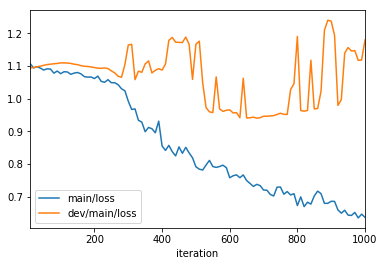

In [36]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "dev/main/loss"]].values, columns=["main/loss", "dev/main/loss"], index=log_df["iteration"]).plot()

開発データのlossが反復とともに増加してしまっています。これは過学習してしまったということですね。

性能を確認しましょう。開発データでlossが最小になったモデルで評価します。

In [37]:
from chainer.serializers import load_npz

In [38]:
def get_iter(path, prefix):
    return int(path.replace(prefix, "").replace(".npz", ""))

files = glob.glob("result/normal_model_*.npz")
best = sorted(files, key=lambda x: get_iter(x, "result/normal_model_"))[-1]
print("Best Model = {}".format(best))

bestmodel = Model()
load_npz(best, bestmodel)

ValueError: invalid literal for int() with base 10: 'result\\normal_model_10'

In [39]:
with configuration.using_config('train', False):
    predicts = bestmodel(train_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Training data ***")
print(classification_report(train_y, predicts_y))


with configuration.using_config('train', False):
    predicts = bestmodel(dev_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Dev data ***")
print(classification_report(dev_y, predicts_y))


with configuration.using_config('train', False):
    predicts = bestmodel(test_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Test data ***")
print(classification_report(test_y, predicts_y))

NameError: name 'bestmodel' is not defined

精度も低いですね。これを解決する方法について確認していきましょう。

## Word2Vecによる初期値設定

Deep Learning技術が発展する初期の頃、Word2Vecという単語ベクトルの学習方法が一世を風靡したことがありました。その後の研究で、Word2Vecで学習した単語ベクトルは、LSTMのEmbeddingレイヤーの初期値として設定すると学習結果を改善することが多いとされています。今回の講義からは詳細を省略しましたが、興味のある方は調べて見てください。今回は使い方だけ押さえておきましょう。

Word2Vecをchainerで学習することは可能ですが、gensimを使うとよりお手軽に学習できます。

In [40]:
from gensim.models.word2vec import Word2Vec

C:\Users\Hiroshi.Hiromax\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


1文1行の文集合を作ります。

In [41]:
sentences = []
for doc in train:
    for sentence in doc:
        sentences.append(sentence.words)

学習します。

In [42]:
word2vec = Word2Vec(sentences, size=embedding_size, seed=np.random.randint(1000), workers=1, min_count=2)
word2vec.init_sims(replace=True)

学習によって得られたベクトルをモデルの初期値に設定します。

In [43]:
initialW = np.random.random((len(vocab) + 1, embedding_size)).astype(np.float32)
for w, i in vocab.items():
    if w in word2vec.wv:
        initialW[i, :] = word2vec.wv[w]

In [44]:
files = glob.glob("result/w2v_model_*")
for file in files:
    os.unlink(file)

In [45]:
model_w2v = Model(initialW=initialW)
classifier = L.Classifier(model_w2v)
optimizer = Adam()
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator, optimizer)
trainer = Trainer(updater, (1000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(10, 'iteration'), name="dev")
trainer.extend(Evaluator(test_iterator, classifier), trigger=(10, 'iteration'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss"]))

logreport = LogReport(trigger=(10, 'iteration'))
trainer.extend(logreport)
trainer.extend(snapshot_object(model_w2v, "w2v_model_{.updater.iteration}.npz"), trigger=MinValueTrigger("dev/main/loss", trigger=(10, 'iteration')))

trainer.run()

iteration   main/loss   dev/main/loss
10          1.13676     1.10882        
20          1.11282     1.1034         
30          1.10703     1.09992        
40          1.09882     1.09787        
50          1.08921     1.09679        
60          1.0867      1.09641        
70          1.08608     1.09617        
80          1.08382     1.0959         
90          1.07217     1.09582        
100         1.07122     1.09593        
110         1.06551     1.09542        
120         1.0645      1.09291        
130         1.05366     1.0889         
140         1.03821     1.0834         
150         1.02924     1.07389        
160         0.999384    1.05988        
170         0.950628    1.04216        
180         0.903705    0.914859       
190         0.840642    0.867112       
200         0.830752    0.890658       
210         0.803932    0.828935       
220         0.761476    0.961701       
230         0.761296    0.844359       
240         0.732796    0.821999       
25

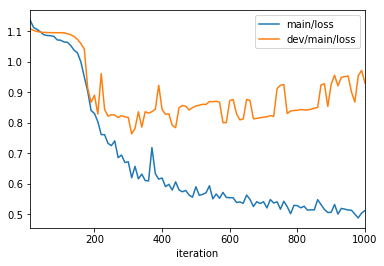

In [46]:
log_df_w2v = pd.DataFrame(logreport.log)
pd.DataFrame(log_df_w2v[["main/loss", "dev/main/loss"]].values, columns=["main/loss", "dev/main/loss"], index=log_df_w2v["iteration"]).plot()

In [47]:
files = glob.glob("result/w2v_model_*.npz")
best = sorted(files, key=lambda x: get_iter(x, "result/w2v_model_"))[-1]
print("Best Model = {}".format(best))

bestmodel_w2v = Model()
load_npz(best, bestmodel_w2v)

ValueError: invalid literal for int() with base 10: 'result\\w2v_model_10'

In [48]:
with configuration.using_config('train', False):
    predicts = bestmodel_w2v(train_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Training data ***")
print(classification_report(train_y, predicts_y))


with configuration.using_config('train', False):
    predicts = bestmodel_w2v(dev_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Dev data ***")
print(classification_report(dev_y, predicts_y))

with configuration.using_config('train', False):
    predicts = bestmodel_w2v(test_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Test data ***")
print(classification_report(test_y, predicts_y))

NameError: name 'bestmodel_w2v' is not defined

通常のランダム値からスタートした場合に比べて、学習データに対するlossがより低いところまで学習できていることがわかります。

## 参考資料

http://deeplearning.net/tutorial/lstm.html